# 2kr Assumptions Tests

In [1]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from IPython.display import display, HTML
%matplotlib inline

def parse_if_number(s):
    try: return float(s)
    except: return True if s=="true" else False if s=="false" else s if s else None

def parse_ndarray(s):
    return np.fromstring(s, sep=' ') if s else None

def get_file_name(name):
    return name.replace(':', '-')

## Config

In [2]:
inputFile = 'data.csv'
repetitionsCount = -1 # -1 = auto-detect
factors = ['R', 'T', 'm', 'D']

# Fitting
distsFit = ['norm'] # Distributions to fit
distsParams = [()] # Distributions params
outlierStddevDistance = 3 # Outliers identification

# Plots
histBinNum = 30 # Histograms
histCenter = True # Center distribution
plotSize = (10, 10)
plotStyle = 'seaborn-whitegrid'
scatterShowLines = False
# Save
saveFigures = False

# Filter scalars
scalarsFilter = ['Floorplan.userCount', 'Floorplan.coveredUsers:sum', 'Floorplan.collisions:sum', 'Floorplan.msgsPerSlot:sum']
# Filter vectors
vectorsFilter = ['Floorplan.coveredUsers:vector']
# Percentiles
percentiles = [0.25, 0.5, 0.75, 0.9, 0.95, 0.99]

# Residuals to compute
residualNames = [
    ('coveredUsersPercent', 'percentage of covered users (residuals)'),
    ('collisions', 'total number of collisions (residuals)'),
    ('msgsPerSlot', 'total number of messages sent (residuals)'),
]

# Transformations
transformations = [
]

intPercentiles = [int(i*100) for i in percentiles]
vecPerfIndexes = []
for intPercentile in intPercentiles:
    vecPerfIndexes.append(('broadcastTime' + str(intPercentile), 'Broadcast time needed to reach the ' + str(intPercentile) + 'th percentile of the coverage'))
for i, d in vecPerfIndexes:
    residualNames.append((i, d + ' (residuals)'))
    transformations.append((i, lambda x: math.log(x)))

## Load scalars

In [3]:
df = pd.read_csv('exported_data/' + inputFile, converters = {
    'attrvalue': parse_if_number,
    'binedges': parse_ndarray,
    'binvalues': parse_ndarray,
    'vectime': parse_ndarray,
    'vecvalue': parse_ndarray,
})

In [4]:
if repetitionsCount <= 0: # auto-detect
    repetitionsCount = int(df[df.attrname == 'repetition']['attrvalue'].max()) + 1
print('Repetitions:', repetitionsCount)

# Computed
factorsCount = len(factors)
configsCount = 2**factorsCount
totalSims = configsCount*repetitionsCount

# Scatter plot whitelists
configsShown = range(0, configsCount)
repetitionsShown = range(0, repetitionsCount)


display(HTML("<style>div.output_scroll { height: auto; max-height: 48em; }</style>"))
pd.set_option('display.max_rows', totalSims)
if saveFigures:
    os.makedirs('figures', exist_ok=True)

Repetitions: 10


In [5]:
scalars = df[(df.type == 'scalar') | ((df.type == 'itervar') & (df.attrname != 'TO')) | ((df.type == 'param') & (df.attrname == 'Floorplan.userCount')) | ((df.type == 'runattr') & (df.attrname == 'repetition'))]
scalars = scalars.assign(qname = scalars.attrname.combine_first(scalars.module + '.' + scalars.name))
for index, row in scalars[scalars.type == 'itervar'].iterrows():
    val = scalars.loc[index, 'attrvalue']
    if isinstance(val, str)  and not all(c.isdigit() for c in val):
        scalars.loc[index, 'attrvalue'] = eval(val)
scalars.value = scalars.value.combine_first(scalars.attrvalue.astype('float64'))
scalars_wide = scalars.pivot_table(index=['run'], columns='qname', values='value')
scalars_wide.sort_values([*factors, 'repetition'], inplace=True)
count = 0
for index in scalars_wide.index:
    config = count // repetitionsCount
    scalars_wide.loc[index, 'config'] = config
    count += 1
scalars_wide = scalars_wide[['config', 'repetition', *factors, *scalarsFilter]]

# coverage
scalars_wide['coveredUsersPercent'] = scalars_wide['Floorplan.coveredUsers:sum'] / (scalars_wide['Floorplan.userCount'] - 1)

## Load vectors

In [6]:
vectors = df[df.type == 'vector']
vectors = vectors.assign(qname = vectors.module + '.' + vectors.name)
for index in scalars_wide.index:
    r = index
    cfg = scalars_wide.loc[index, 'config']
    rep = scalars_wide.loc[index, 'repetition']
    vectors.loc[vectors.run == r, 'config'] = cfg
    vectors.loc[vectors.run == r, 'repetition'] = rep
vectors = vectors[vectors.qname.isin(vectorsFilter)]
vectors.sort_values(['config', 'repetition', 'qname'], inplace=True)
vectors = vectors[['config', 'repetition', 'qname', 'vectime', 'vecvalue']]

## Compute scalars from vectors

In [7]:
def get_percentile(percentile, vectime, vecvalue, totalvalue):
    tofind = percentile * totalvalue
    idx = 0
    csum = vecvalue.cumsum()
    for value in csum:
        if value >= tofind:
            return vectime[idx]
        idx += 1
    return math.inf

for index, row in vectors.iterrows():
    for vecPerf, percentile in zip(vecPerfIndexes, percentiles):
        vecPerfIndex = vecPerf[0]
        cfg = row['config']
        rep = row['repetition']
        if vecPerfIndex.startswith('broadcastTime'):
            total = scalars_wide[(scalars_wide['config'] == cfg) & (scalars_wide['repetition'] == rep)]['Floorplan.userCount'].values[0] - 1
        else:
            raise Exception('Need to specify total for ' + vecPerfIndex + '. (coding required)')
        value = get_percentile(percentile, row['vectime'], row['vecvalue'], total)
        scalars_wide.loc[(scalars_wide['config'] == cfg) & (scalars_wide['repetition'] == rep), vecPerfIndex] = value

## Apply transformations

In [8]:
for col, transform in transformations:
    scalars_wide[col] = scalars_wide[col].map(transform, 'ignore')

## Compute residuals

In [9]:
# coverage
scalars_wide['coveredUsersPercentMean'] = scalars_wide.groupby(factors)['coveredUsersPercent'].transform('mean')
scalars_wide['coveredUsersPercentResidual'] = scalars_wide['coveredUsersPercent'] - scalars_wide['coveredUsersPercentMean']

# collisions
scalars_wide['collisionsMean'] = scalars_wide.groupby(factors)['Floorplan.collisions:sum'].transform('mean')
scalars_wide['collisionsResidual'] = scalars_wide['Floorplan.collisions:sum'] - scalars_wide['collisionsMean']

# msgsPerSlot
scalars_wide['msgsPerSlotMean'] = scalars_wide.groupby(factors)['Floorplan.msgsPerSlot:sum'].transform('mean')
scalars_wide['msgsPerSlotResidual'] = scalars_wide['Floorplan.msgsPerSlot:sum'] - scalars_wide['msgsPerSlotMean']

# vectors
skipped = []
for vecPerfIndex, _ in vecPerfIndexes:
    mean = scalars_wide.groupby(factors)[vecPerfIndex].transform('mean')
    nextVect = False
    for value in mean.values:
        if math.isinf(value):
            skipped.append(vecPerfIndex)
            nextVect = True
            continue
    if nextVect:
        continue
    scalars_wide[vecPerfIndex + 'Mean'] = mean
    scalars_wide[vecPerfIndex + 'Residual'] = scalars_wide[vecPerfIndex] - scalars_wide[vecPerfIndex + 'Mean']
for i, d in vecPerfIndexes:
    if i not in skipped:
        continue
    print(i + ' skipped due to infinite values in observations')
    residualNames.remove((i, d + ' (residuals)'))

## Residual distributions (histograms)

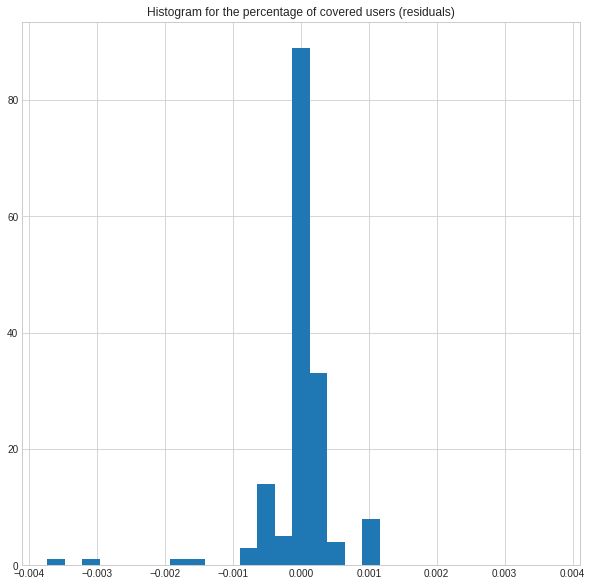

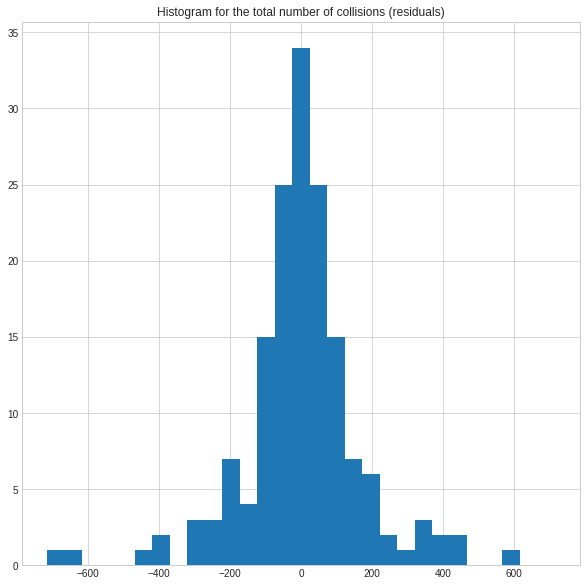

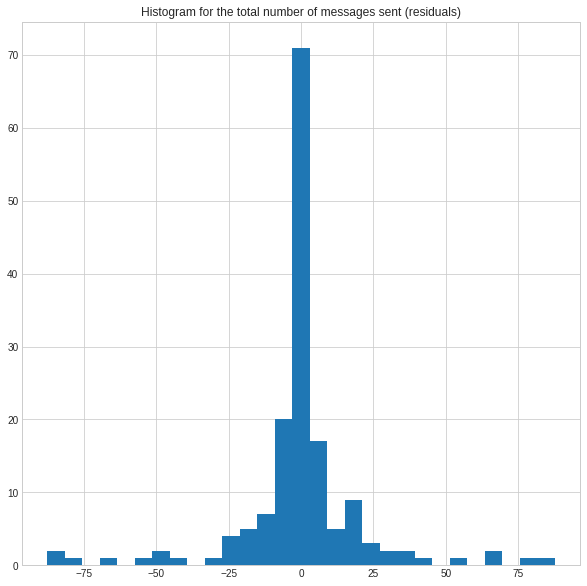

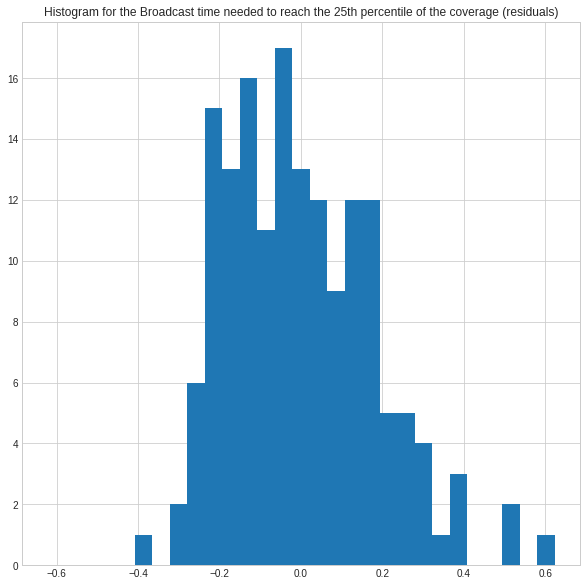

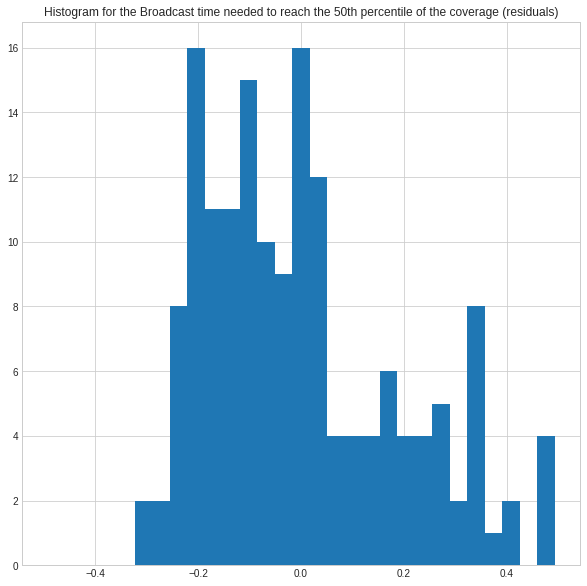

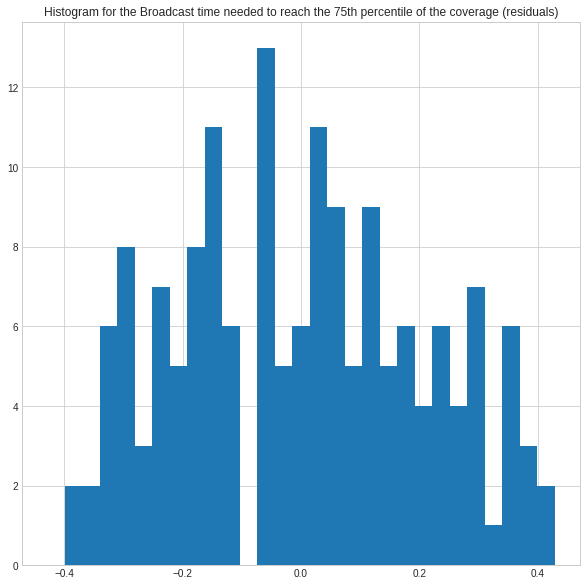

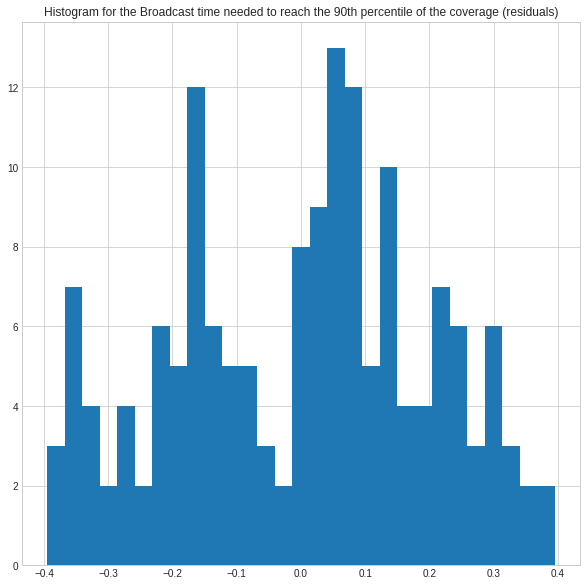

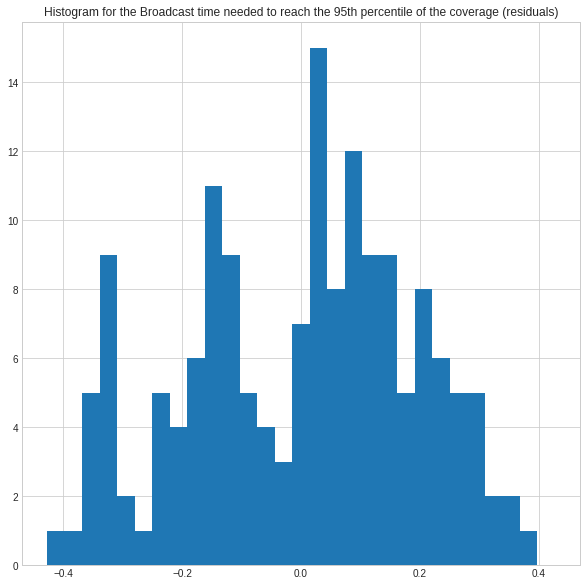

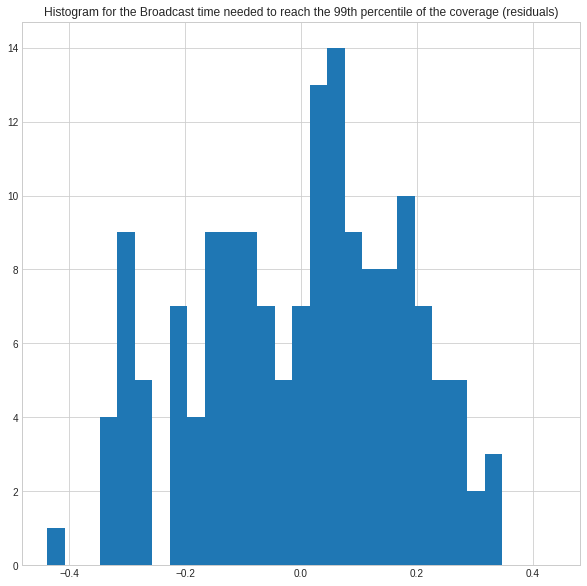

In [10]:
for varname, vardesc in residualNames:
    plt.figure(figsize=plotSize)
    plt.style.use(plotStyle)
    minval = scalars_wide[varname + 'Residual'].min()
    maxval = scalars_wide[varname + 'Residual'].max()
    if histCenter:
        limit = max(abs(minval), abs(maxval))
        minval = -limit
        maxval = limit
    plt.hist(scalars_wide[varname + 'Residual'].values.tolist(), bins=np.linspace(minval, maxval, histBinNum))
    plt.title('Histogram for the ' + vardesc)
    if saveFigures:
        fig = plt.gcf()
        fig.savefig('figures/' + get_file_name(varname) + '-hist.png')
    plt.show()

## Distribution fitting

Trying to fit to a norm distribution:


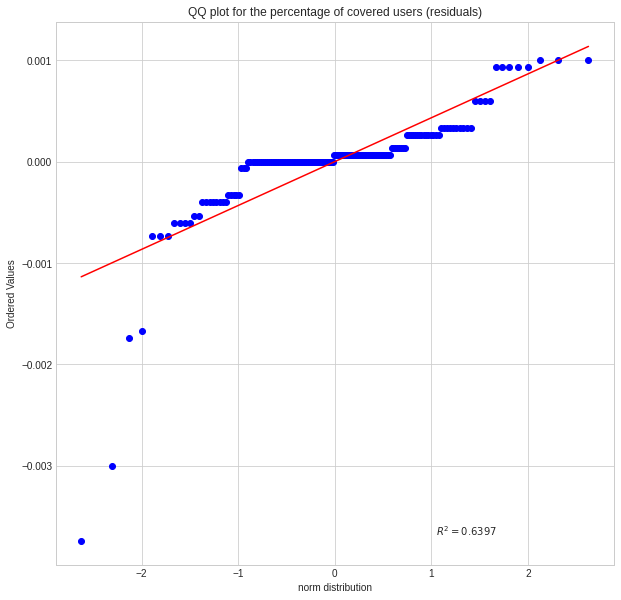

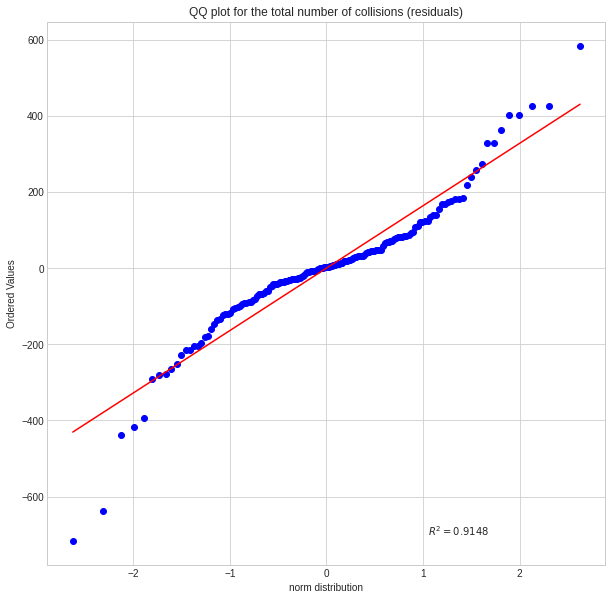

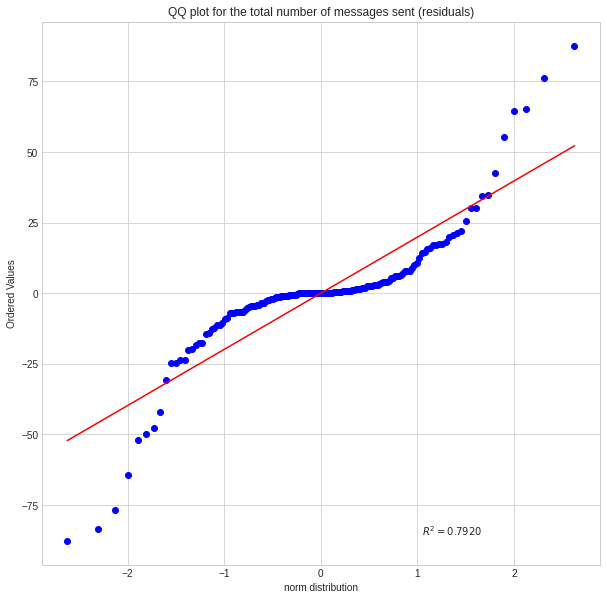

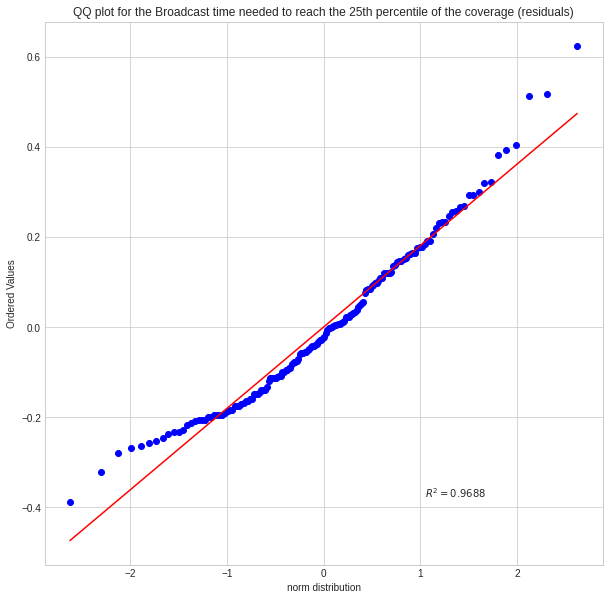

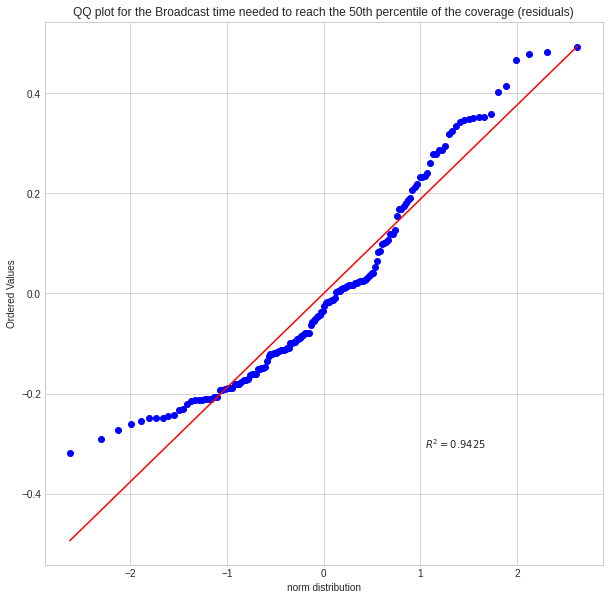

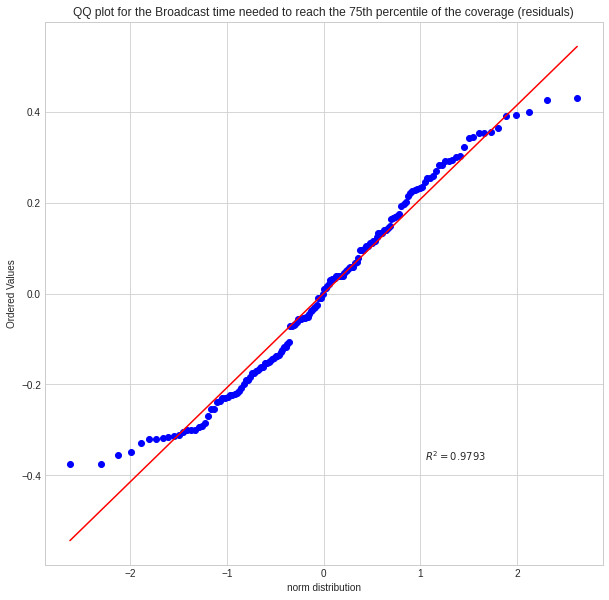

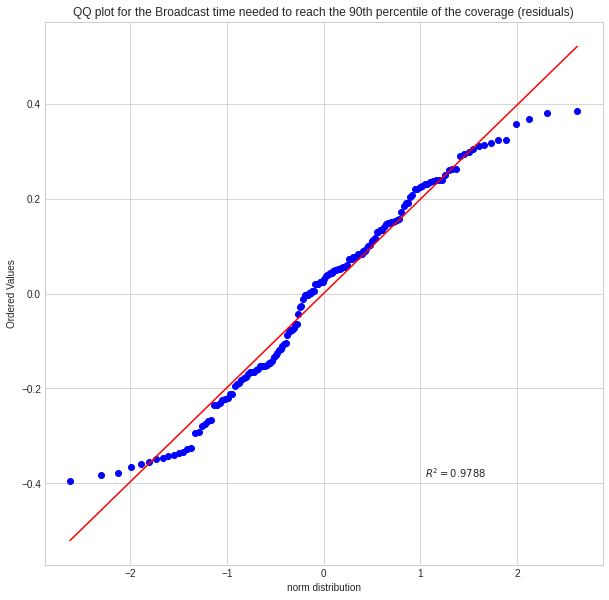

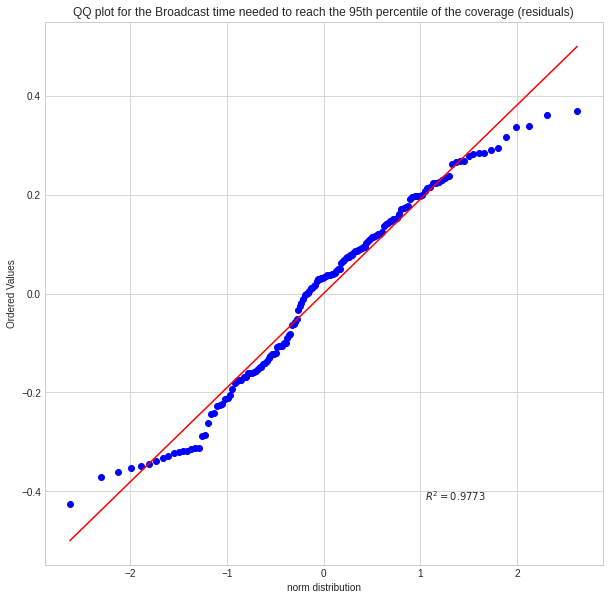

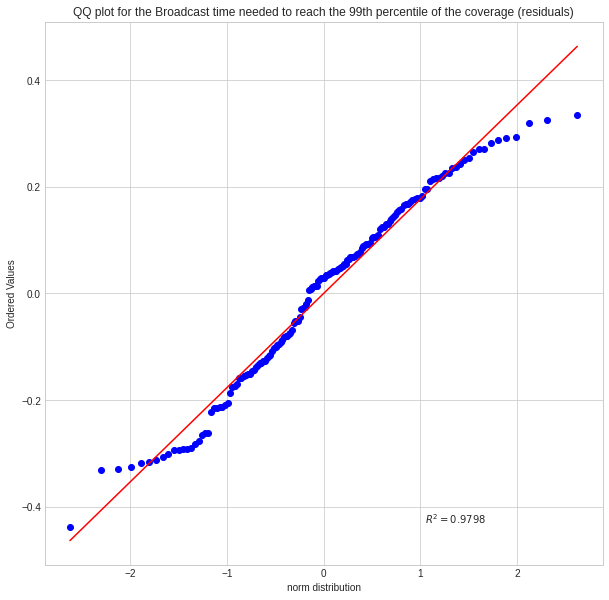

In [11]:
for distribution, params in zip(distsFit, distsParams):
    print('Trying to fit to a', distribution + ('({})'.format(', '.join(map(str, params))) if len(params) > 0 else ''), 'distribution:')
    for varname, vardesc in residualNames:
        plt.figure(figsize=plotSize)
        plt.style.use(plotStyle)
        residuals = scalars_wide[varname + 'Residual'].values.tolist()
        result, line = stats.probplot(residuals, dist=distribution, sparams=params, plot=plt, rvalue=True)
        #osm, _ = result
        #slope, intercept, _ = line
        plt.title("QQ plot for the " + vardesc)
        plt.xlabel(distribution + " distribution")
        if saveFigures:
            fig = plt.gcf()
            fig.savefig('figures/' + get_file_name(varname) + '-' + distribution + '-fit.png')
        plt.show()

### Outliers

In [12]:
for varname, vardesc in residualNames:
    print('Outliers for the ' + vardesc)
    stddev = scalars_wide[varname + 'Residual'].std()
    limit = outlierStddevDistance*stddev
    print('total mean:', scalars_wide[varname + 'Mean'].mean())
    print('stddev:', stddev)
    print(str(outlierStddevDistance) + '*stddev:', limit)
    outliers = scalars_wide[np.abs(scalars_wide[varname + 'Residual']) > limit]
    display(outliers[['config', 'repetition', *factors, varname + 'Residual', varname + 'Mean']])

Outliers for the percentage of covered users (residuals)
total mean: 0.9997623415610402
stddev: 0.0005351032908286166
3*stddev: 0.0016053098724858497


qname,config,repetition,R,T,m,D,coveredUsersPercentResidual,coveredUsersPercentMean
run,,,,,,,,
Rectangular2kr-2-20210601-17:26:00-21413,0.0,2.0,10.0,5.0,3.0,5.0,-0.003002,0.998999
Rectangular2kr-124-20210601-17:33:55-23855,5.0,4.0,10.0,10.0,3.0,10.0,-0.001734,0.999066
Rectangular2kr-128-20210601-17:33:34-23858,5.0,8.0,10.0,10.0,3.0,10.0,-0.003736,0.999066
Rectangular2kr-14-20210601-17:27:09-21415,8.0,4.0,20.0,5.0,3.0,5.0,-0.001668,0.999666


Outliers for the total number of collisions (residuals)
total mean: 3025.443749999998
stddev: 169.63956796357365
3*stddev: 508.91870389072096


qname,config,repetition,R,T,m,D,collisionsResidual,collisionsMean
run,,,,,,,,
Rectangular2kr-92-20210601-17:31:31-22250,12.0,2.0,20.0,10.0,3.0,5.0,582.4,4086.6
Rectangular2kr-97-20210601-17:31:29-22253,12.0,7.0,20.0,10.0,3.0,5.0,-715.6,4086.6
Rectangular2kr-114-20210601-17:33:32-23727,14.0,4.0,20.0,10.0,7.0,5.0,-637.9,7417.9


Outliers for the total number of messages sent (residuals)
total mean: 1315.075000000002
stddev: 22.106176034491458
3*stddev: 66.31852810347438


qname,config,repetition,R,T,m,D,msgsPerSlotResidual,msgsPerSlotMean
run,,,,,,,,
Rectangular2kr-92-20210601-17:31:31-22250,12.0,2.0,20.0,10.0,3.0,5.0,87.4,849.6
Rectangular2kr-94-20210601-17:32:09-22250,12.0,4.0,20.0,10.0,3.0,5.0,-83.6,849.6
Rectangular2kr-96-20210601-17:31:14-22253,12.0,6.0,20.0,10.0,3.0,5.0,-76.6,849.6
Rectangular2kr-97-20210601-17:31:29-22253,12.0,7.0,20.0,10.0,3.0,5.0,-87.6,849.6
Rectangular2kr-139-20210601-17:33:49-23928,13.0,9.0,20.0,10.0,3.0,10.0,76.3,688.7


Outliers for the Broadcast time needed to reach the 25th percentile of the coverage (residuals)
total mean: 3.7867132908049586
stddev: 0.18145643574602083
3*stddev: 0.5443693072380624


qname,config,repetition,R,T,m,D,broadcastTime25Residual,broadcastTime25Mean
run,,,,,,,,
Rectangular2kr-95-20210601-17:30:53-22253,12.0,5.0,20.0,10.0,3.0,5.0,0.622734,3.471611


Outliers for the Broadcast time needed to reach the 50th percentile of the coverage (residuals)
total mean: 4.344437709994521
stddev: 0.19167871753277613
3*stddev: 0.5750361525983284


qname,config,repetition,R,T,m,D,broadcastTime50Residual,broadcastTime50Mean
run,,,,,,,,


Outliers for the Broadcast time needed to reach the 75th percentile of the coverage (residuals)
total mean: 4.81101319373655
stddev: 0.20686347508575093
3*stddev: 0.6205904252572527


qname,config,repetition,R,T,m,D,broadcastTime75Residual,broadcastTime75Mean
run,,,,,,,,


Outliers for the Broadcast time needed to reach the 90th percentile of the coverage (residuals)
total mean: 5.042258132861547
stddev: 0.19819274149591126
3*stddev: 0.5945782244877338


qname,config,repetition,R,T,m,D,broadcastTime90Residual,broadcastTime90Mean
run,,,,,,,,


Outliers for the Broadcast time needed to reach the 95th percentile of the coverage (residuals)
total mean: 5.115112510463101
stddev: 0.19038126059752306
3*stddev: 0.5711437817925692


qname,config,repetition,R,T,m,D,broadcastTime95Residual,broadcastTime95Mean
run,,,,,,,,


Outliers for the Broadcast time needed to reach the 99th percentile of the coverage (residuals)
total mean: 5.1897324668161655
stddev: 0.17629897442333237
3*stddev: 0.5288969232699972


qname,config,repetition,R,T,m,D,broadcastTime99Residual,broadcastTime99Mean
run,,,,,,,,


## Independency test

qname,config,R,T,m,D
run,,,,,
Rectangular2kr-0-20210601-17:25:06-21413,0.0,10.0,5.0,3.0,5.0
Rectangular2kr-40-20210601-17:27:41-21764,1.0,10.0,5.0,3.0,10.0
Rectangular2kr-20-20210601-17:25:06-21417,2.0,10.0,5.0,7.0,5.0
Rectangular2kr-60-20210601-17:28:08-21909,3.0,10.0,5.0,7.0,10.0
Rectangular2kr-80-20210601-17:30:43-22228,4.0,10.0,10.0,3.0,5.0
Rectangular2kr-120-20210601-17:32:25-23855,5.0,10.0,10.0,3.0,10.0
Rectangular2kr-100-20210601-17:31:29-23723,6.0,10.0,10.0,7.0,5.0
Rectangular2kr-140-20210601-17:34:02-24071,7.0,10.0,10.0,7.0,10.0
Rectangular2kr-10-20210601-17:25:06-21415,8.0,20.0,5.0,3.0,5.0


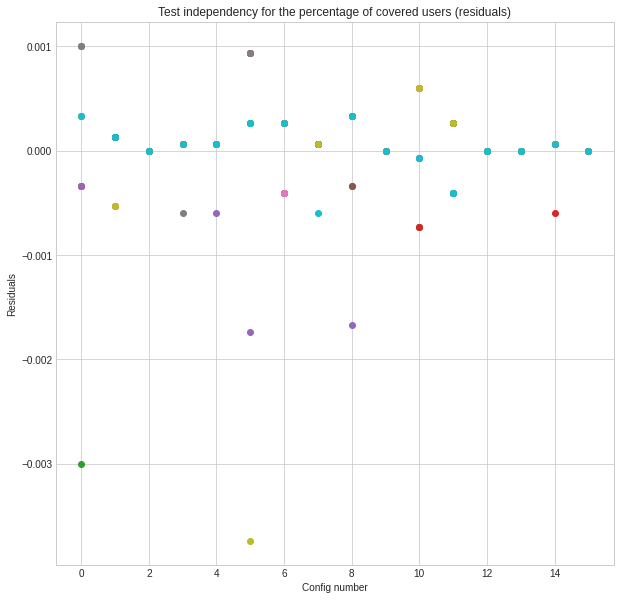

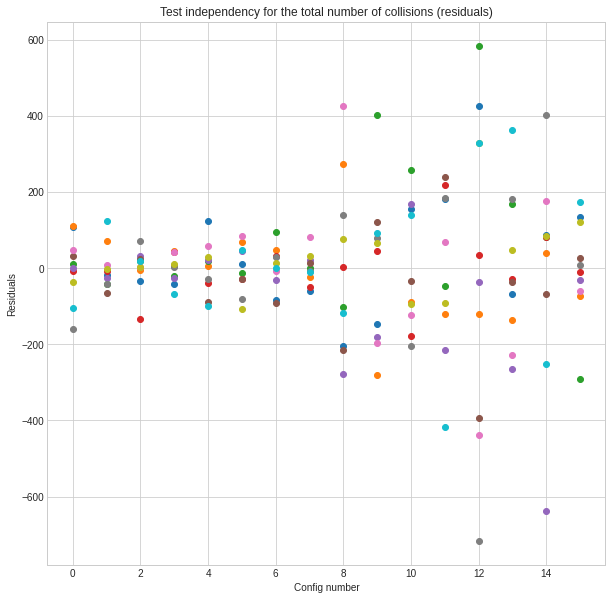

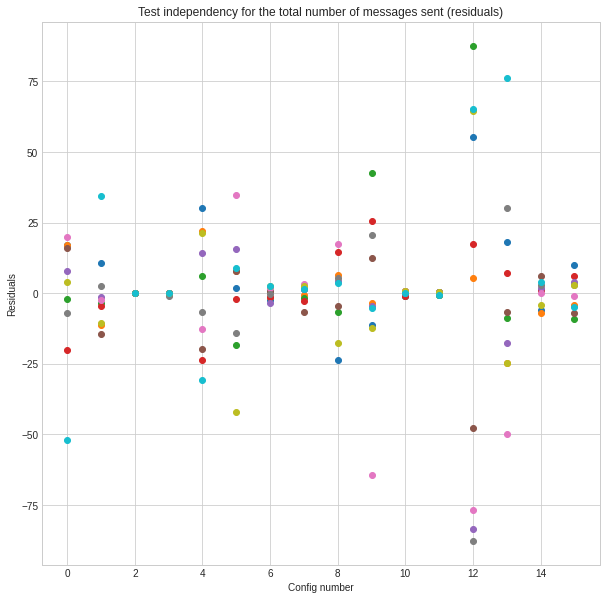

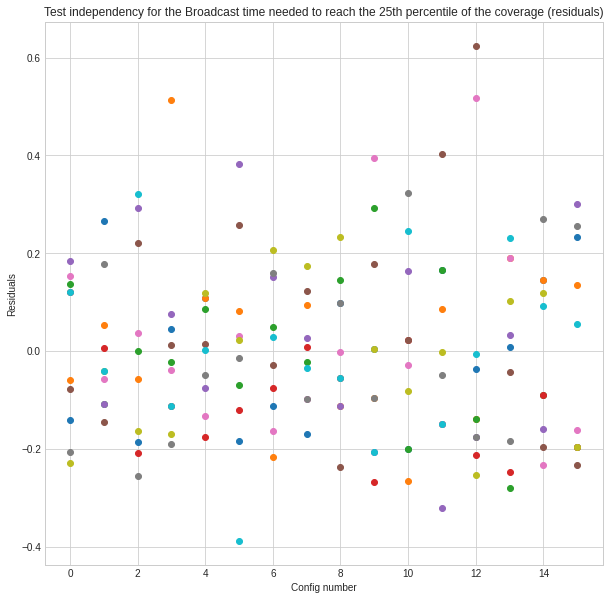

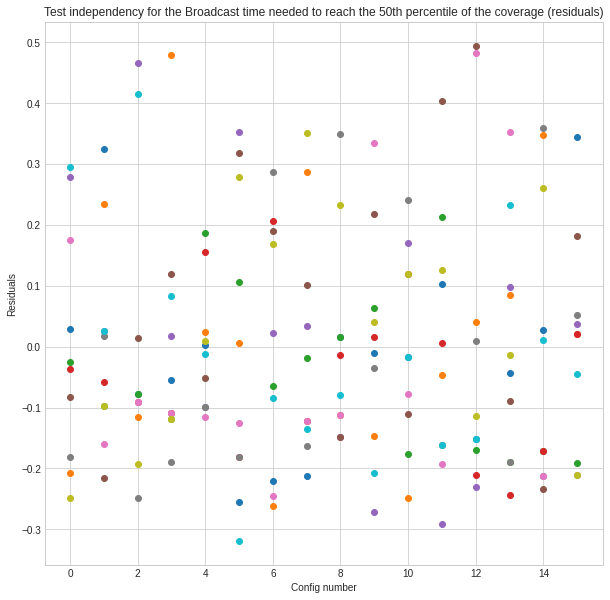

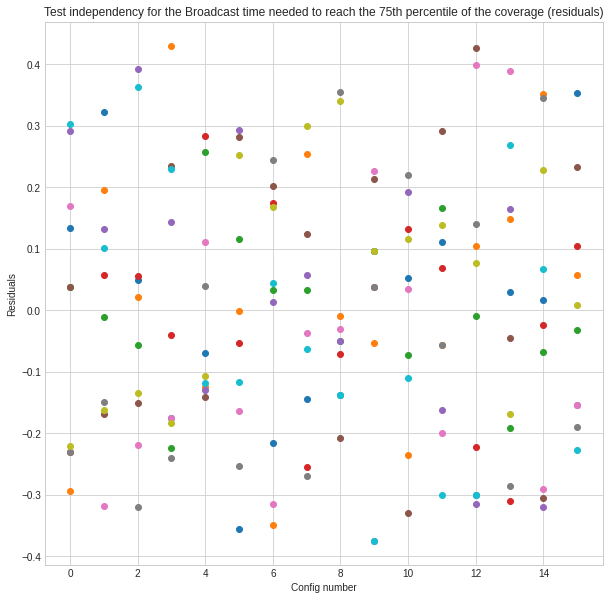

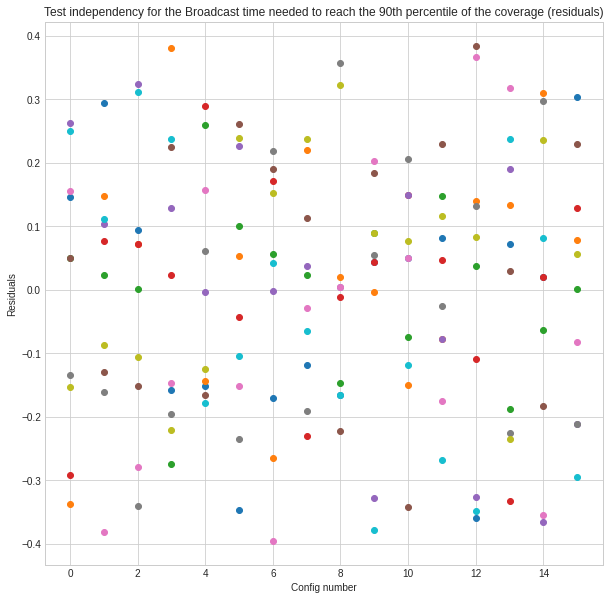

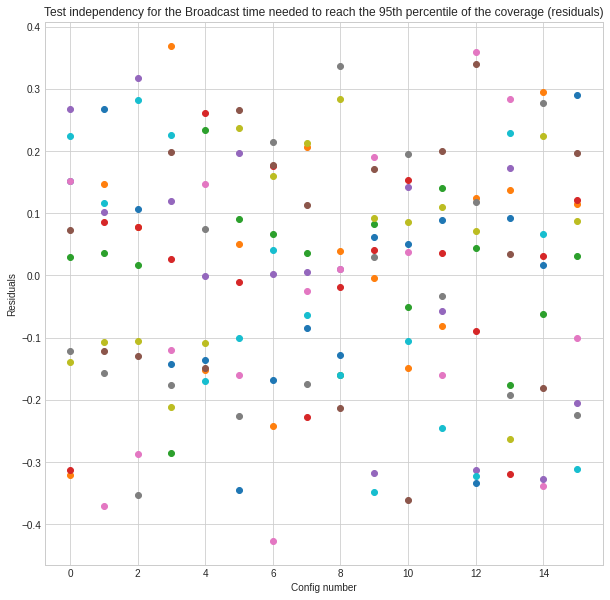

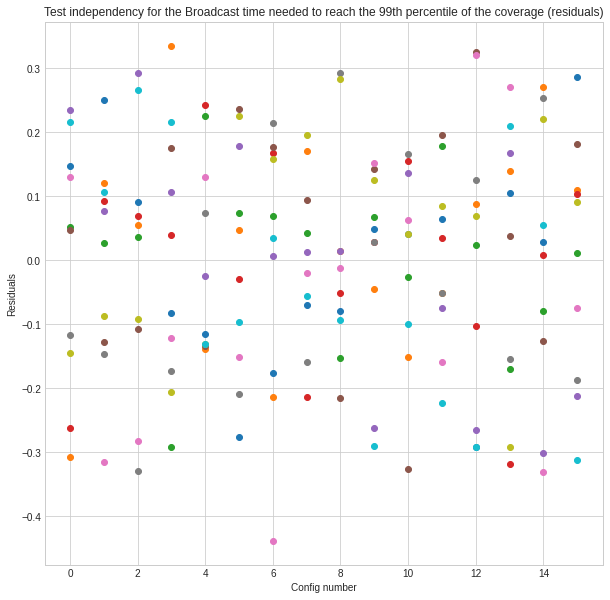

In [13]:
display(scalars_wide.loc[(scalars_wide.repetition == 0) & (scalars_wide.config.isin(configsShown))][['config', *factors]])
for varname, vardesc in residualNames:
    y = []
    x = []
    for config in range(0, configsCount):
        if config not in configsShown:
            continue
        x.append([config] * len(repetitionsShown))
        y.append(scalars_wide.loc[(scalars_wide.config == config) & (scalars_wide.repetition.isin(repetitionsShown))][varname + 'Residual'].values.tolist())
    plt.figure(figsize=plotSize)
    plt.style.use(plotStyle)
    plt.plot(x, y, 'o' + ('-' if scatterShowLines else ''))
    plt.title("Test independency for the " + vardesc)
    plt.xlabel("Config number")
    plt.ylabel("Residuals")
    if saveFigures:
        fig = plt.gcf()
        fig.savefig('figures/' + get_file_name(varname) + '-independency.png')
    plt.show()

## Finite variance test

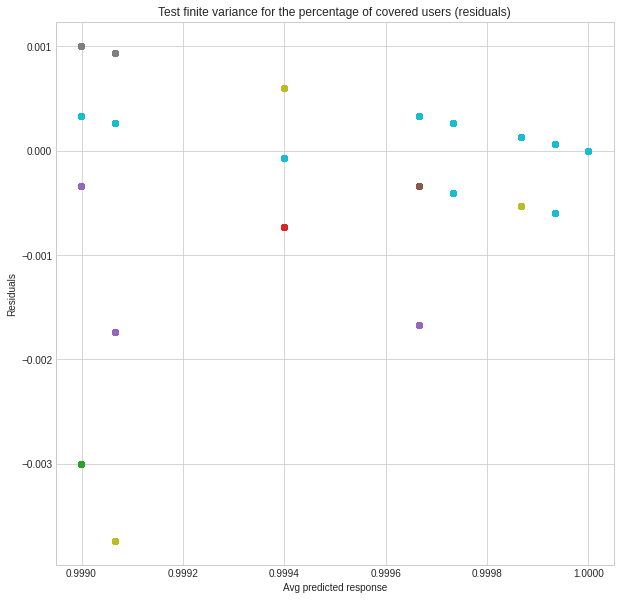

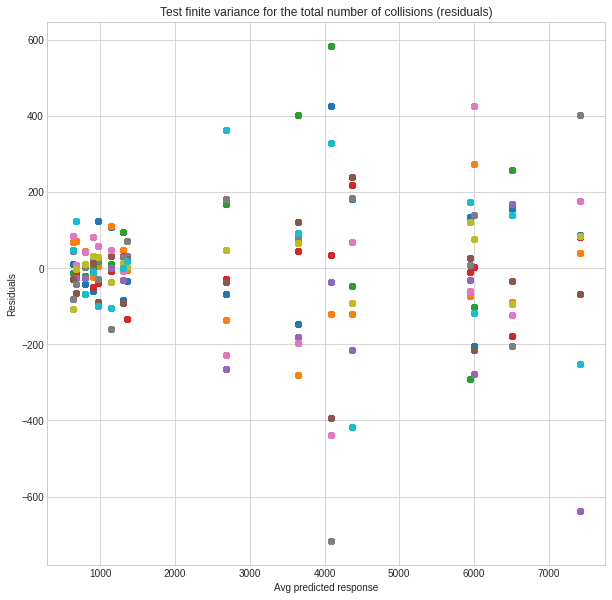

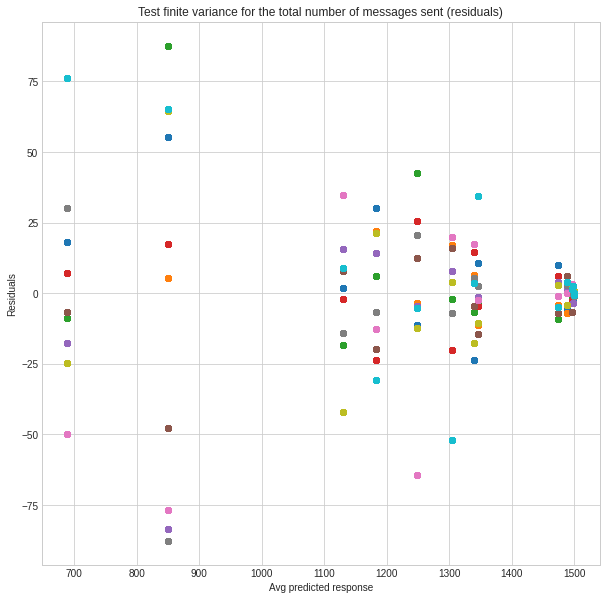

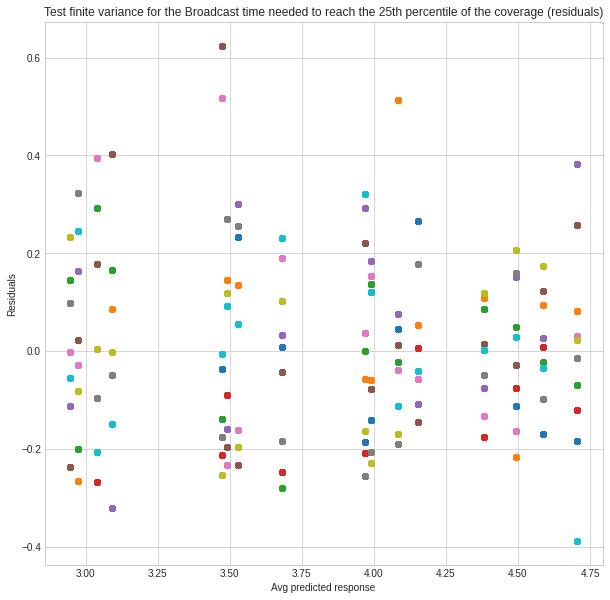

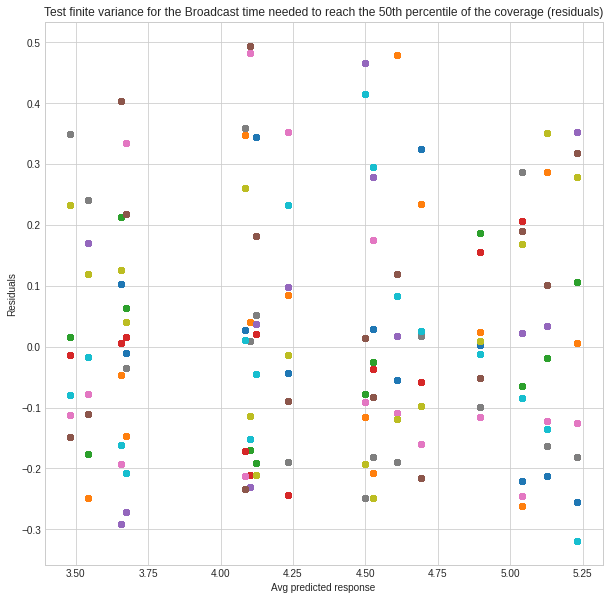

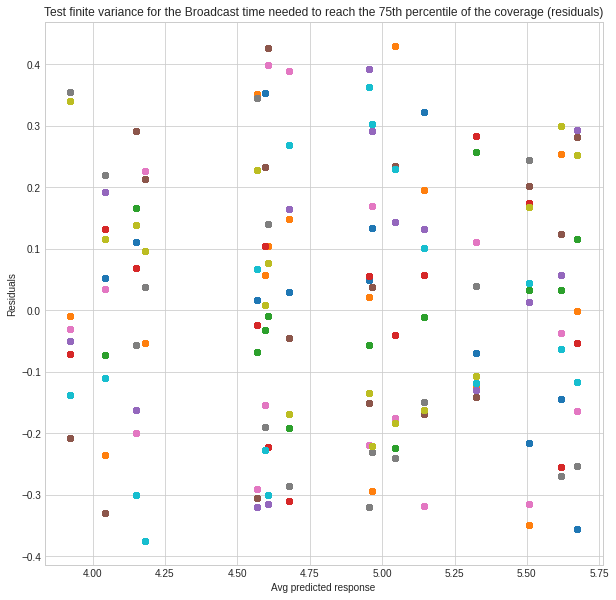

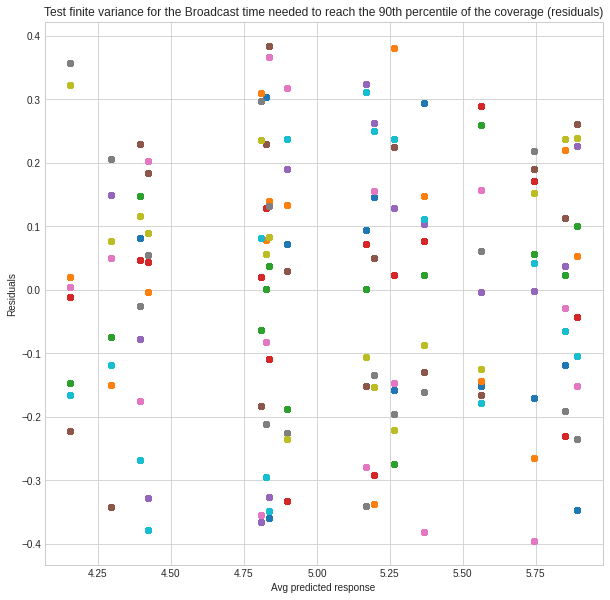

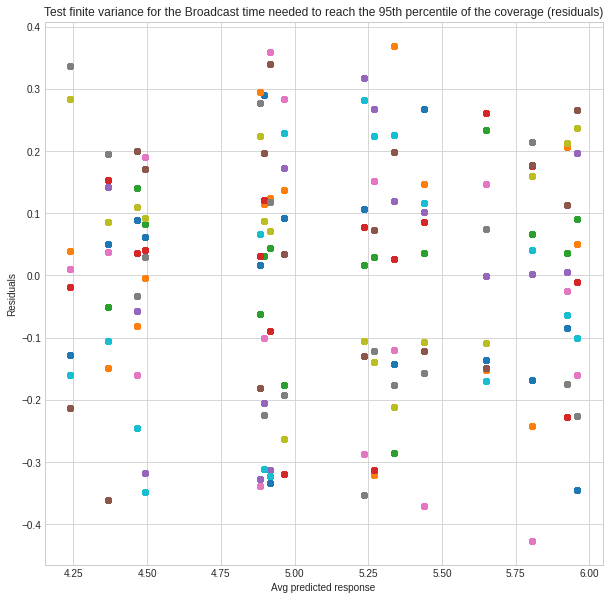

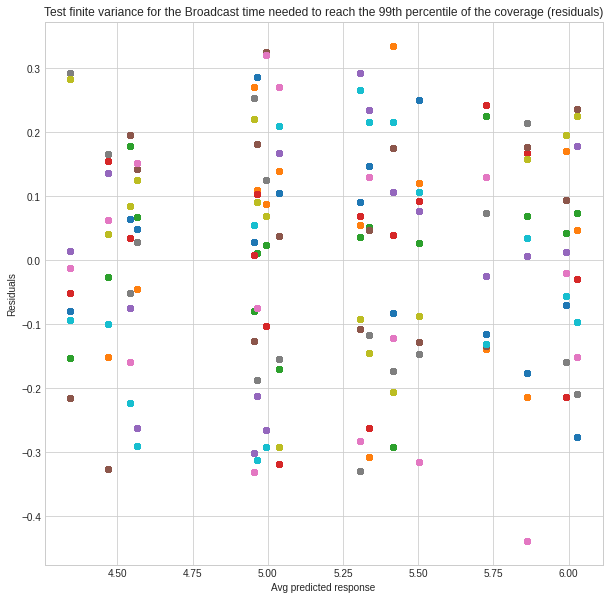

In [14]:
for varname, vardesc in residualNames:
    y = []
    x = []
    scalars_wide.sort_values([varname + 'Mean', 'repetition'], inplace=True)
    for _, row in scalars_wide.iterrows():
        config = row['config']
        if config not in configsShown:
            continue
        x.append(scalars_wide.loc[(scalars_wide.config == config) & (scalars_wide.repetition.isin(repetitionsShown))][varname + 'Mean'].values.tolist())
        y.append(scalars_wide.loc[(scalars_wide.config == config) & (scalars_wide.repetition.isin(repetitionsShown))][varname + 'Residual'].values.tolist())
    plt.figure(figsize=plotSize)
    plt.style.use(plotStyle)
    plt.plot(x, y, 'o' + ('-' if scatterShowLines else ''))
    plt.title("Test finite variance for the " + vardesc)
    plt.xlabel("Avg predicted response")
    plt.ylabel("Residuals")
    if saveFigures:
        fig = plt.gcf()
        fig.savefig('figures/' + get_file_name(varname) + '-variance.png')
    plt.show()